In [30]:
# Load necessary libraries (ensure these are installed!)
library(Seurat)
library(tidyverse)
library(semla)
library(Matrix) # For handling dgCMatrix

In [31]:


# --- 2. Define File Paths ---
base_path <- "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_ST/ST_image_tif_data/"

# Define the molecular data paths
rds_file_path <- paste0(base_path, "GSE211785_EXPORT_ST_counts.rds")
metadata_file_path <- paste0(base_path, "GSE211785_ST_metadata.txt")
umap_file_path <- paste0(base_path, "GSE211785_EXPORT_ST_umap.txt")

# --- 3. Load Counts and Re-create Seurat Object ---
# The RDS file contains the raw sparse matrix.
raw_counts <- readRDS(rds_file_path)
seurat_combined <- CreateSeuratObject(
    counts = raw_counts,
    project = "Kidney_ST_Combined" 
)
print("✅ Seurat object created from raw counts.")

# --- 4. Load and Merge Metadata ---
# This step correctly links the metadata (orig.ident, celltype, Status) to the spots.
metadata_supp <- read.delim(
    file = metadata_file_path,
    sep = "\t",
    header = TRUE,
    row.names = 1 # CRITICAL: Use Spot Barcodes as row names
)

# Add the external metadata to the Seurat object
seurat_combined <- AddMetaData(
    object = seurat_combined, 
    metadata = metadata_supp
)
print("✅ External metadata merged (orig.ident, celltype, Status are populated).")

# --- 5. Load and Add UMAP Coordinates ---
# This step adds the pre-calculated 2D coordinates for visualization.
umap_coords <- read.delim(
    file = umap_file_path,
    sep = "\t",
    header = TRUE,
    row.names = 1
)

# Filter coordinates to match the cells/spots in the Seurat object
umap_coords_filtered <- as.matrix(umap_coords[colnames(seurat_combined), ])

# Create and add the UMAP DimReduc object
seurat_combined[["umap"]] <- CreateDimReducObject(
    embeddings = umap_coords_filtered,
    key = "UMAP_",
    assay = DefaultAssay(seurat_combined)
)
print("✅ UMAP coordinates added.")

# --- 6. Final Check ---
print("--- Final Object Structure Summary ---")
print(seurat_combined)
print(head(seurat_combined@meta.data[, c("orig.ident", "Status", "nCount_RNA")]))

[1] "✅ Seurat object created from raw counts."
[1] "✅ External metadata merged (orig.ident, celltype, Status are populated)."
[1] "✅ UMAP coordinates added."
[1] "--- Final Object Structure Summary ---"
An object of class Seurat 
12511 features across 37143 samples within 1 assay 
Active assay: RNA (12511 features, 0 variable features)
 1 layer present: counts
 1 dimensional reduction calculated: umap
                     orig.ident  Status nCount_RNA
AAACAAGTATCTCCCA-1_1  HK2770_ST Disease       4049
AAACATTTCCCGGATT-1_1  HK2770_ST Disease       3928
AAACCGGGTAGGTACC-1_1  HK2770_ST Disease       4294
AAACCGTTCGTCCAGG-1_1  HK2770_ST Disease       4074
AAACCTAAGCAGCCGG-1_1  HK2770_ST Disease       4367
AAACGGGCGTACGGGT-1_1  HK2770_ST Disease       3424


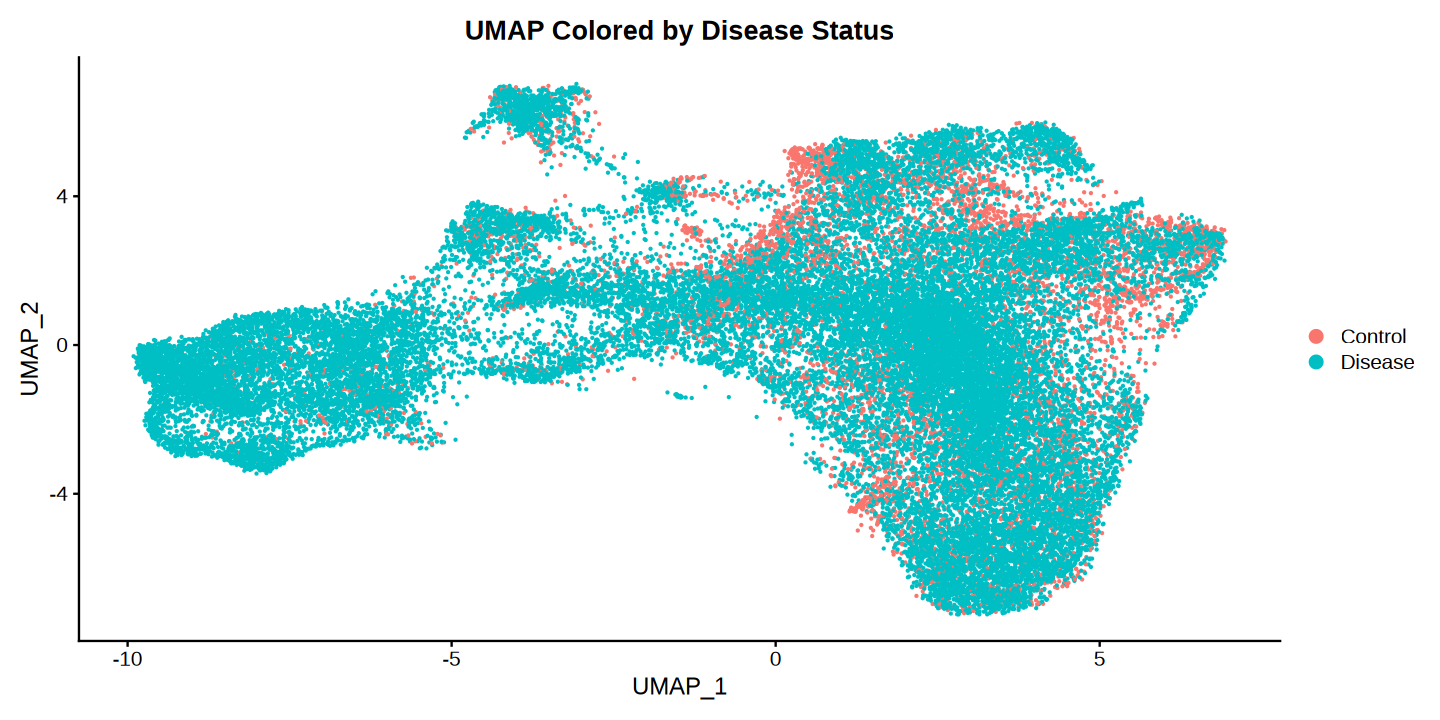

In [32]:
library(Seurat)
DimPlot(seurat_combined, 
        reduction = "umap", 
        group.by = "Status", 
        pt.size = 0.001) +
    labs(title = "UMAP Colored by Disease Status") +
    theme(plot.title = element_text(hjust = 0.5))

In [33]:
# Check the dimensions of the Seurat object
# The first number (rows) is the number of genes.
# The second number (columns) is the number of spots.
dim(seurat_combined)

# Alternatively, just get the number of genes (features)
number_of_genes_in_object <- nrow(seurat_combined)
print(paste("The number of genes/features in the Seurat object is:", number_of_genes_in_object))

[1] 12511 37143

[1] "The number of genes/features in the Seurat object is: 12511"


In [34]:
# 1. Define the genes of interest
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# 2. Get the list of all genes (features) present in the Seurat object
all_genes_in_seurat <- rownames(seurat_combined)

# 3. Find which genes of interest are PRESENT
present_genes <- intersect(genes_of_interest, all_genes_in_seurat)

# 4. Find which genes of interest are MISSING
missing_genes <- setdiff(genes_of_interest, all_genes_in_seurat)

# 5. Print the results

cat("--- Gene Presence Check Results ---\n")
cat("Total Genes of Interest:", length(genes_of_interest), "\n")
cat("----------------------------------\n")

cat("✅ Genes PRESENT in Seurat Object (", length(present_genes), " found):\n")
if (length(present_genes) > 0) {
    print(present_genes)
} else {
    cat("  (None found)\n")
}
cat("\n")

cat("❌ Genes MISSING from Seurat Object (", length(missing_genes), " missing):\n")
if (length(missing_genes) > 0) {
    print(missing_genes)
} else {
    cat("  (All genes found)\n")
}

--- Gene Presence Check Results ---
Total Genes of Interest: 24 
----------------------------------
✅ Genes PRESENT in Seurat Object ( 23  found):
 [1] "ALDOB"   "ALDH8A1" "SLC5A10" "PAX8"    "CUBN"    "SLC17A3" "ACSF2"  
 [8] "ARMC7"   "BDH2"    "BICC1"   "CRB2"    "CYFIP2"  "EFHD1"   "HOXA9"  
[15] "KCNJ15"  "LGALS2"  "OCIAD2"  "PEPD"    "RGL3"    "SHMT1"   "SLC2A9" 
[22] "SLC9A3"  "TM7SF3" 

❌ Genes MISSING from Seurat Object ( 1  missing):
[1] "NAT8B"


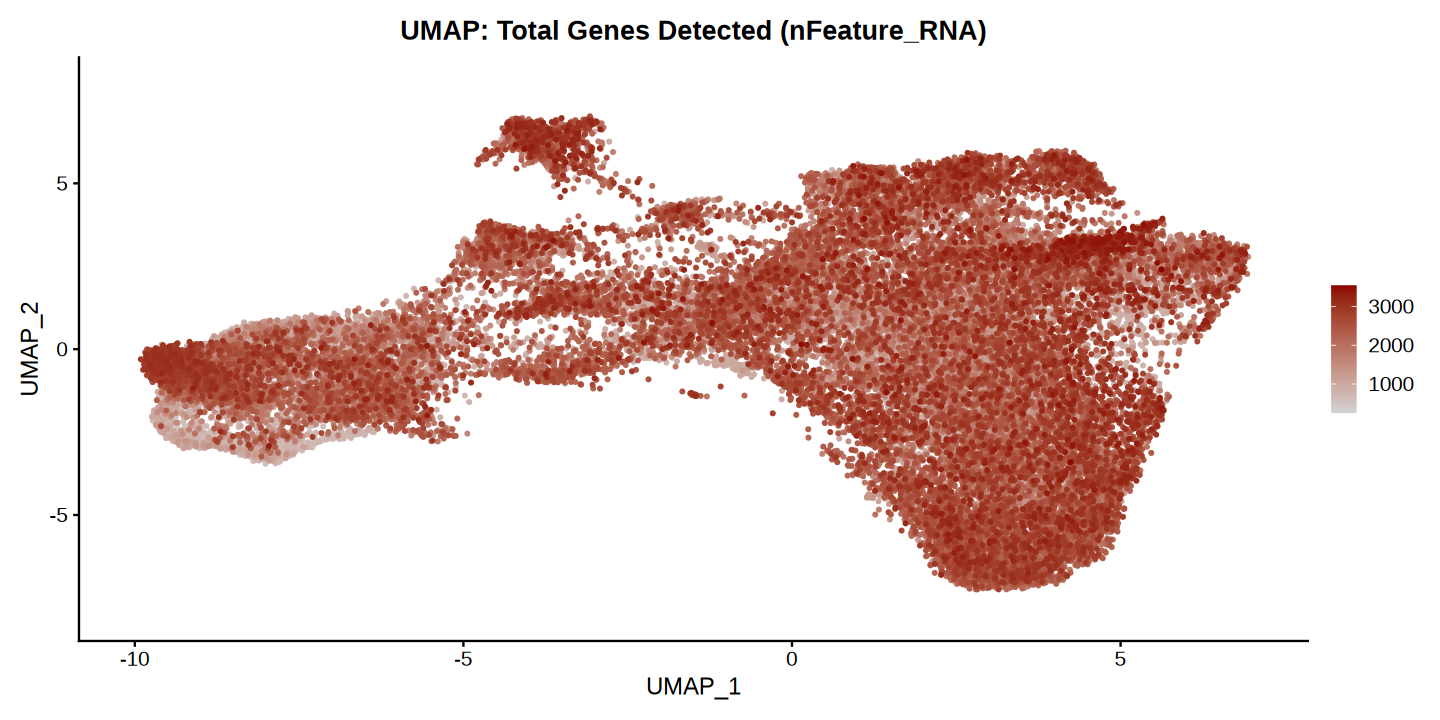

In [35]:
library(Seurat)

# Plot the total number of genes detected per spot
FeaturePlot(seurat_combined, 
            features = "nFeature_RNA", 
            reduction = "umap", 
            pt.size = 0.5,
            order = TRUE, # Plot spots with high expression last (on top)
            cols = c("lightgrey", "darkred")) +
    labs(title = "UMAP: Total Genes Detected (nFeature_RNA)") +
    theme(plot.title = element_text(hjust = 0.5))

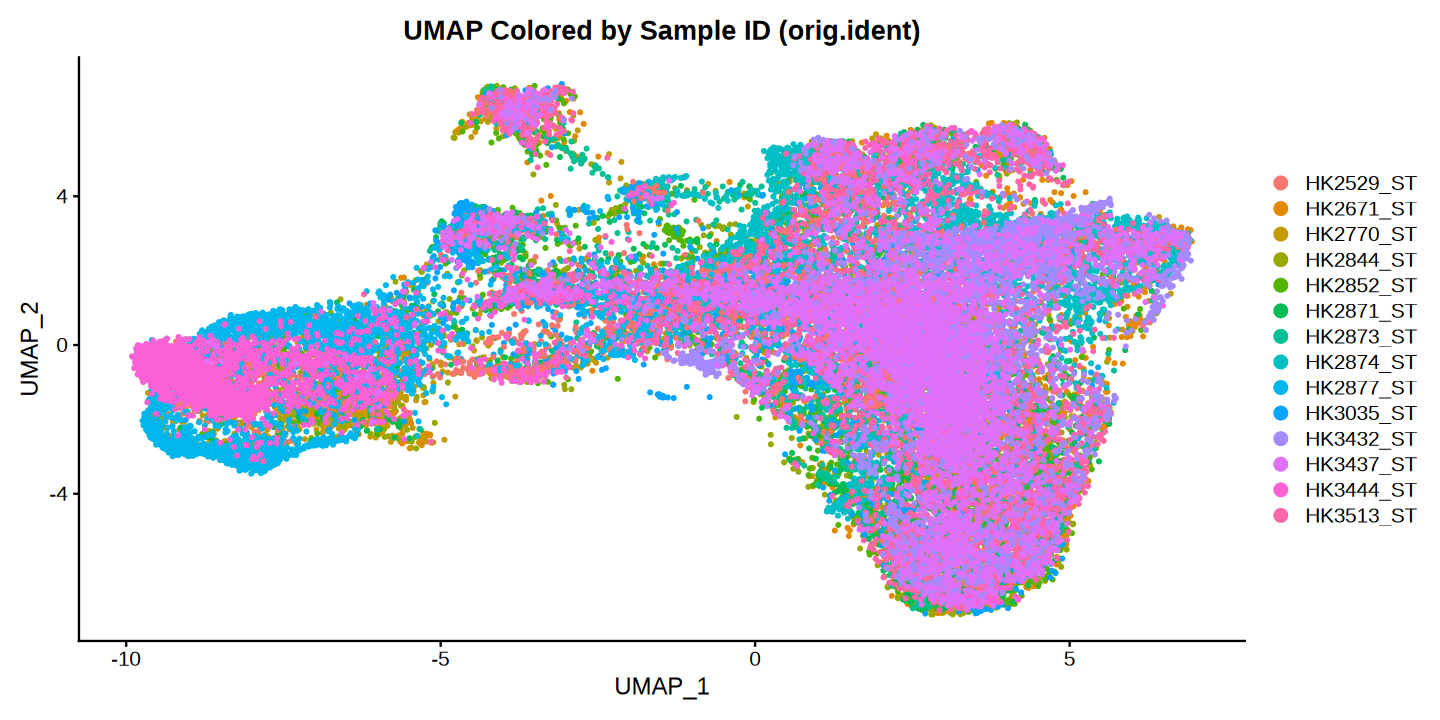

In [36]:
library(Seurat)

# Plot the UMAP embedding, colored by the 'orig.ident' (Sample ID) column
# This plot is essential for assessing batch effects or technical variation.
DimPlot(seurat_combined, 
        reduction = "umap", 
        group.by = "orig.ident", 
        pt.size = 0.5) +
    labs(title = "UMAP Colored by Sample ID (orig.ident)") +
    theme(plot.title = element_text(hjust = 0.5))

In [37]:
library(dplyr)
library(tibble)

# 1. Extract the two required columns: orig.ident (Sample ID) and Status
sample_status_table <- seurat_combined@meta.data %>%
    # Select only the relevant columns
    select(orig.ident, Status) %>%
    # Remove duplicate rows (since every spot has the same status for its sample)
    distinct() %>%
    # Rename the columns for clarity
    rename("Sample_ID_HK" = orig.ident, "Disease_Status" = Status) %>%
    # Sort by the Sample ID
    arrange(Sample_ID_HK) %>%
    # Convert to a clean tibble for display
    as_tibble()

# 2. Print the table
print("--- Sample ID to Disease Status Mapping ---")
print(sample_status_table)

[1] "--- Sample ID to Disease Status Mapping ---"
# A tibble: 14 × 2
   Sample_ID_HK Disease_Status
   <chr>        <chr>         
 1 HK2529_ST    Disease       
 2 HK2671_ST    Control       
 3 HK2770_ST    Disease       
 4 HK2844_ST    Disease       
 5 HK2852_ST    Control       
 6 HK2871_ST    Disease       
 7 HK2873_ST    Disease       
 8 HK2874_ST    Control       
 9 HK2877_ST    Disease       
10 HK3035_ST    Disease       
11 HK3432_ST    Disease       
12 HK3437_ST    Disease       
13 HK3444_ST    Disease       
14 HK3513_ST    Disease       


In [38]:
str(seurat_combined)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay5' [package "SeuratObject"] with 8 slots
  .. .. .. ..@ layers    :List of 1
  .. .. .. .. ..$ counts:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. .. ..@ i       : int [1:66045289] 7 17 18 21 73 100 120 129 135 146 ...
  .. .. .. .. .. .. ..@ p       : int [1:37144] 0 951 2590 5418 7890 10444 11948 14407 16358 19537 ...
  .. .. .. .. .. .. ..@ Dim     : int [1:2] 12511 37143
  .. .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. .. ..$ : NULL
  .. .. .. .. .. .. ..@ x       : num [1:66045289] 1 1 1 1 1 2 2 1 1 2 ...
  .. .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ cells     :Formal class 'LogMap' [package "SeuratObject"] with 1 slot
  .. .. .. .. .. ..@ .Data: logi [1:37143, 1] TRUE TRUE TRUE TRUE TRUE TRUE ...
  .. .. .. .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. .. .. .. ..

In [39]:
# Use the colnames() function to extract and print all column names
# from the metadata slot (@meta.data) of the Seurat object.
colnames(seurat_combined@meta.data)



[1] "orig.ident"       "nCount_RNA"       "nFeature_RNA"     "nCount_Spatial"  
[5] "nFeature_Spatial" "nCount_SCT"       "nFeature_SCT"     "celltype"        
[9] "Status"

In [40]:
library(Seurat)

# 1. Set the default assay (to prevent the last error)
DefaultAssay(seurat_combined) <- "RNA"

# 2. Normalize the data (if not done already)
seurat_combined <- NormalizeData(seurat_combined)

# 3. Find and Scale features (standard Seurat pipeline)
seurat_combined <- FindVariableFeatures(seurat_combined)
seurat_combined <- ScaleData(seurat_combined)

print("✅ Data normalization complete. Proceeding to plot.")

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



[1] "✅ Data normalization complete. Proceeding to plot."


In [41]:
# Check and print all unique values in the Status column
unique_statuses <- unique(seurat_combined@meta.data$Status)
print(unique_statuses)

[1] "Disease" "Control"


In [42]:
seurat_combined@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,celltype,Status
,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<chr>,<chr>
AAACAAGTATCTCCCA-1_1,HK2770_ST,4049,951,39948.319,6205,4049,951,MyoFib,Disease
AAACATTTCCCGGATT-1_1,HK2770_ST,3928,1639,17512.733,4730,3928,1639,Fib,Disease
AAACCGGGTAGGTACC-1_1,HK2770_ST,4294,2828,6267.544,3130,4294,2828,Endo_Peritubular,Disease
AAACCGTTCGTCCAGG-1_1,HK2770_ST,4074,2472,17895.595,5773,4074,2472,IC,Disease
AAACCTAAGCAGCCGG-1_1,HK2770_ST,4367,2554,5620.211,2739,4367,2554,Fib,Disease
AAACGGGCGTACGGGT-1_1,HK2770_ST,3424,1504,11483.483,3955,3424,1504,Fib,Disease
AAACGGTTGCGAACTG-1_1,HK2770_ST,4379,2459,9115.721,3556,4379,2459,Fib,Disease
AAACTCGGTTCGCAAT-1_1,HK2770_ST,4241,1951,6077.721,2224,4241,1951,Mac,Disease
AAACTGCTGGCTCCAA-1_1,HK2770_ST,4651,3179,9010.867,4266,4651,3179,Endo_Peritubular,Disease


In [43]:
# Define the list of genes of interest
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# 1. Ensure the correct identity is set for the x-axis (celltype)
# Assuming the 'celltype' information is stored in the metadata of seurat_combined
seurat_combined <- SetIdent(seurat_combined, value = "celltype")



In [44]:
# 1. Define the list of genes of interest
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# --- Data Preparation (Crucial for Heatmap) ---

# Note: DoHeatmap typically works best on 'scale.data'.
# If you haven't run ScaleData() yet, you should run it now
# on the RNA assay for the genes of interest.

seurat_combined <- Seurat::ScaleData(
    object = seurat_combined,
    features = genes_of_interest,
    assay = "RNA"
)

# --- Subset for iPT cells only ---

# 2. Subset the object to only include cells that belong to the 'iPT' cell type.
# Assuming 'celltype' is the metadata column containing the cell type names.
iPT_cells_only <- subset(seurat_combined, subset = celltype == "iPT")


Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”


Warning message in DoHeatmap(object = iPT_cells_only, features = genes_of_interest, :
“The following features were omitted as they were not found in the scale.data layer for the RNA assay: NAT8B”


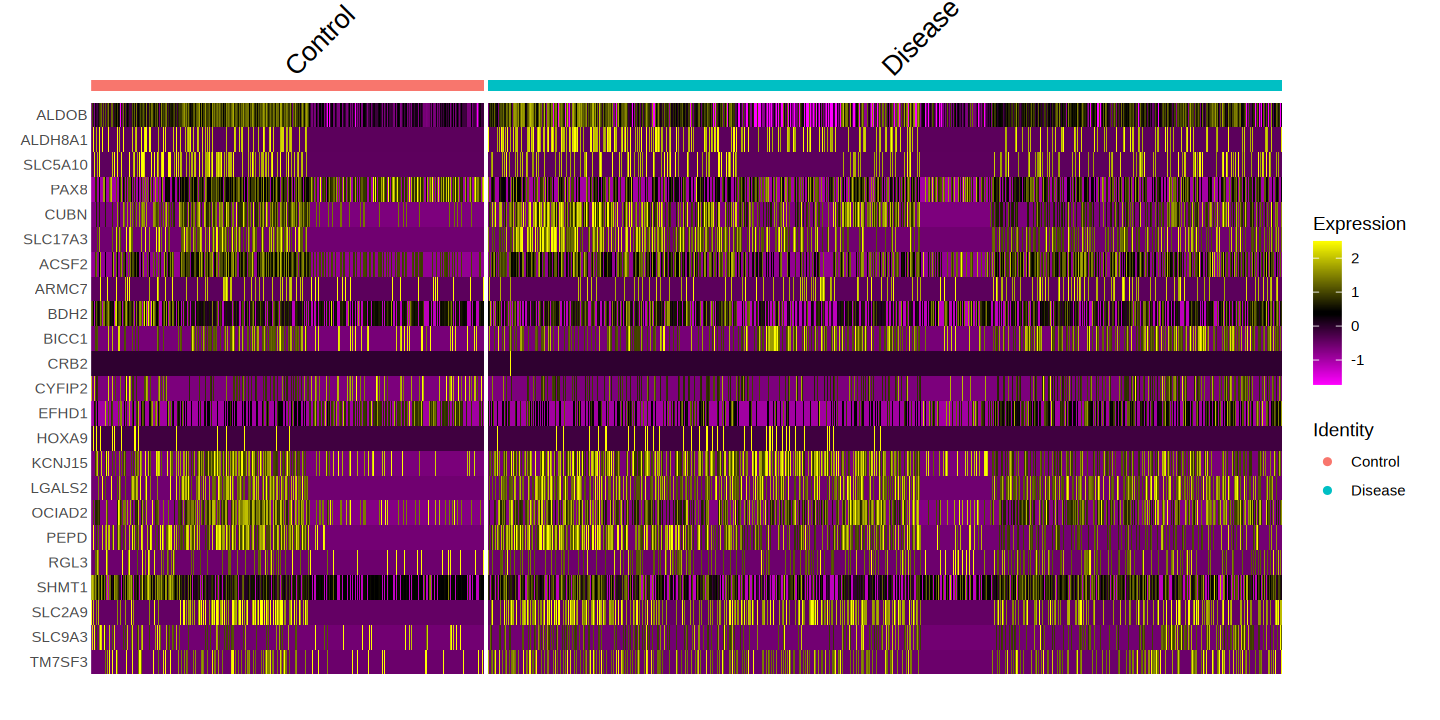

In [45]:

# 3. Generate the Heatmap
# - features: The genes to plot (rows)
# - group.by: The metadata column to group the columns (cells) by (Status)
# - assay: The assay to use (RNA)
# - slot: Use 'scale.data' for heatmap visualization (default and recommended)
# - label: Whether to label the groups (Status)
# - draw.lines: Adds dividing lines between the Control and Disease groups
# Set the plot size options (e.g., 12 inches wide by 6 inches high)
options(
    repr.plot.width = 12,
    repr.plot.height = 6
)
DoHeatmap(
    object = iPT_cells_only,
    features = genes_of_interest,
    group.by = "Status",
    assay = "RNA",
    slot = "scale.data", # Scaled data is standard for heatmaps
    label = TRUE,
    draw.lines = TRUE
)

Centering and scaling data matrix

Warning message in DoHeatmap(object = iPT_cells_only, features = genes_of_interest, :
“The following features were omitted as they were not found in the scale.data layer for the RNA assay: NAT8B”


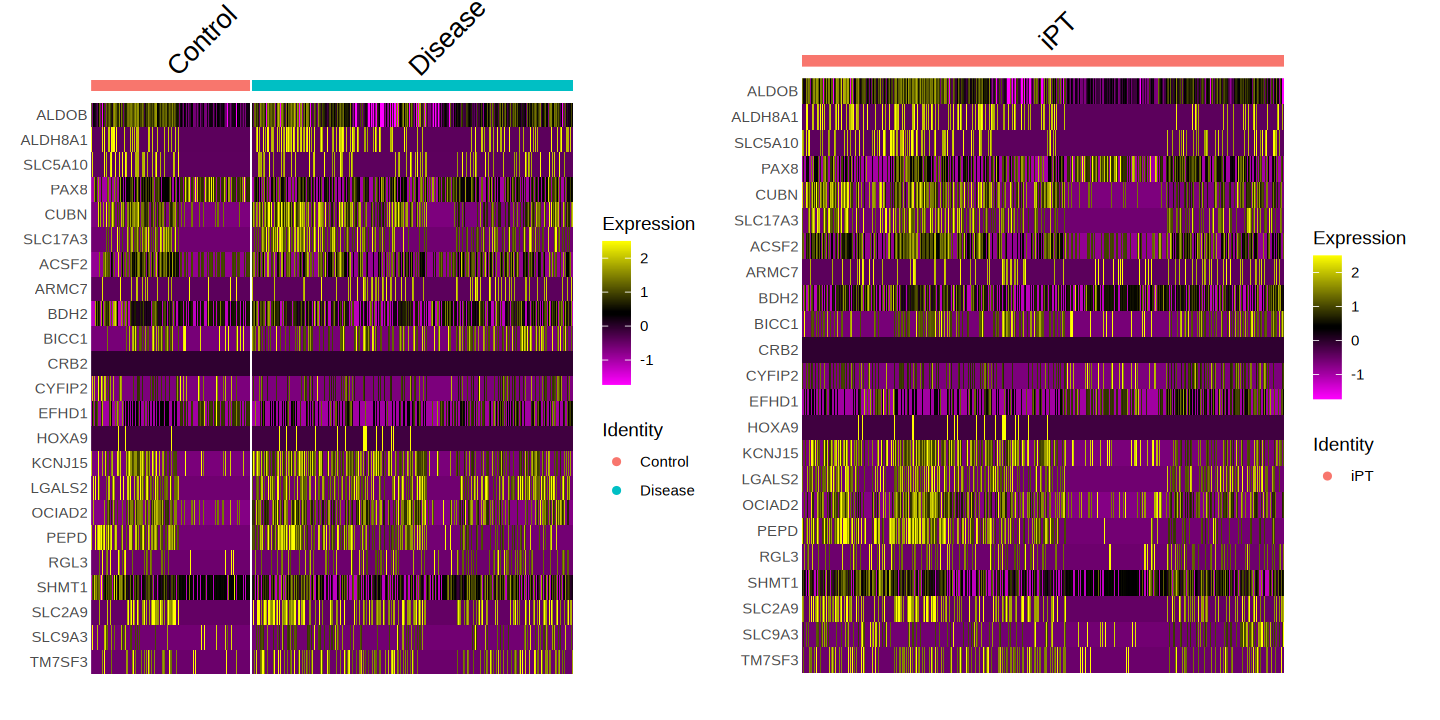

In [46]:
# 1. Set Plot Size Options (Run this first!)
options(
    repr.plot.width = 12,
    repr.plot.height = 6
)

# 2. Define the list of genes of interest
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# 3. Data Preparation and Subsetting (Ensure these steps were run before)
# It's assumed 'seurat_combined' has the required metadata ('celltype' and 'Status')

# Scale the data for the heatmap (if not done already)
seurat_combined <- Seurat::ScaleData(
    object = seurat_combined,
    features = genes_of_interest,
    assay = "RNA"
)

# Subset the object to only include iPT cells
iPT_cells_only <- subset(seurat_combined, subset = celltype == "iPT")


# 4. Generate the Heatmap
# To show both 'Status' and 'celltype' as annotation bars:
DoHeatmap(
    object = iPT_cells_only,
    features = genes_of_interest,
    # Group by Status first, then display celltype
    group.by = c("Status", "celltype"), 
    assay = "RNA",
    slot = "scale.data", 
    label = TRUE,
    draw.lines = TRUE
)

Warning message:
“The following requested variables were not found: NAT8B”


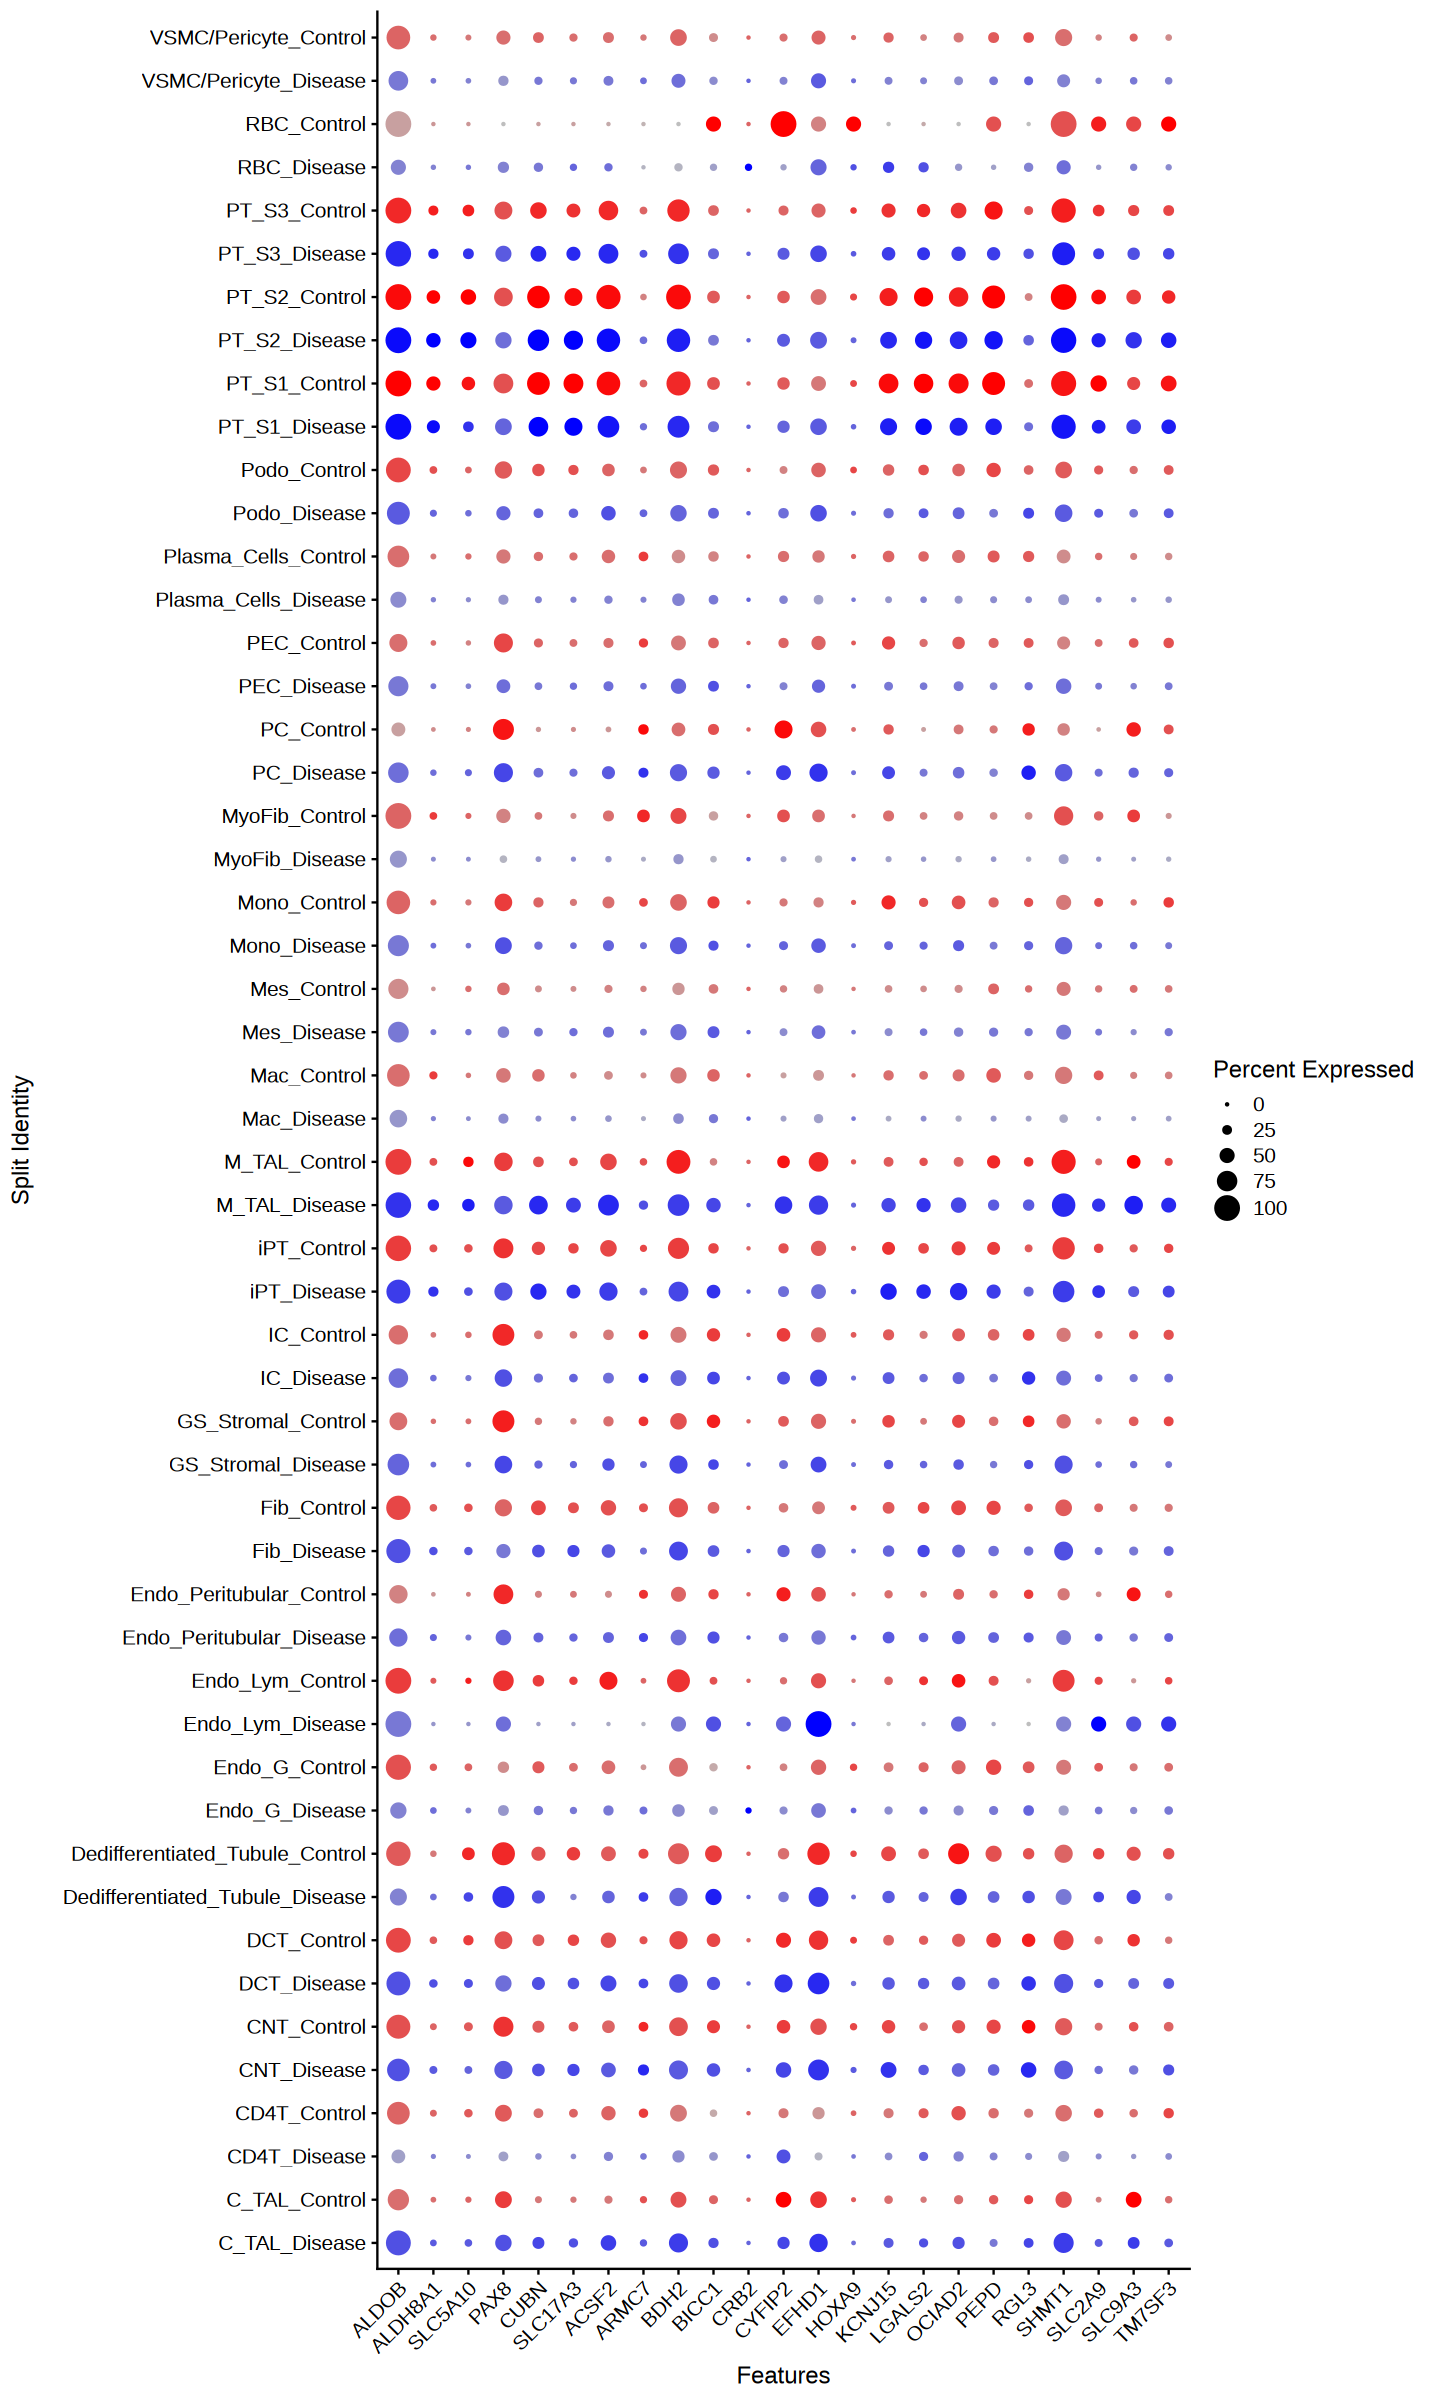

In [48]:
# 1. Set Plot Size Options (Using the options from the previous step)
# This will make the plot area 12 inches wide by 6 inches high
options(
    repr.plot.width = 12,
    repr.plot.height = 20
)

# 2. Define the list of genes of interest (if you haven't already)
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# 3. Generate the DotPlot
# - features: The genes to plot (on the X-axis by default)
# - group.by: The metadata column for the Y-axis groups (cell types)
# - split.by: The metadata column to divide the plot into panels (Status)
# - cols: A list of colors to use for the split.by conditions (optional, but good practice)
DotPlot(
    object = seurat_combined, 
    features = genes_of_interest, 
    group.by = "celltype", 
    split.by = "Status",
    cols = c("blue", "red") # Example colors for Control/Disease
) + RotatedAxis()

In [51]:
# --- 1. Define Genes and Prepare Seurat Object ---

# Define the list of genes of interest
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# Assuming 'seurat_combined' is your Seurat object with 'celltype' and 'Status' metadata.

# Create the crucial combined grouping column (e.g., 'iPT_Disease', 'iPT_Healthy')
seurat_combined$celltype.status <- paste(
    seurat_combined$celltype, 
    seurat_combined$Status, 
    sep = "_"
)

# Set the new combined column as the active identity
Idents(seurat_combined) <- "celltype.status"

In [53]:
# Check how many cells have the MyoFib_Healthy identity
table(seurat_combined$celltype.status)["MyoFib_Healthy"]

# Alternatively, check the underlying metadata columns:
table(seurat_combined$celltype, seurat_combined$Status)

<NA> 
  NA

                         
                          Control Disease
  C_TAL                      1764    6927
  CD4T                         69     497
  CNT                         174     705
  DCT                         129     603
  Dedifferentiated_Tubule      31     190
  Endo_G                       65     294
  Endo_Lym                     82       2
  Endo_Peritubular             99     417
  Fib                         143    3040
  GS_Stromal                  484    1759
  IC                          227     742
  iPT                         944    1907
  M_TAL                        76     258
  Mac                          40    1059
  Mes                          87     527
  Mono                         86     853
  MyoFib                       13    1108
  PC                          918     683
  PEC                         107     713
  Plasma_Cells                 57    1444
  Podo                        129     514
  PT_S1                       471    1818
  PT_S2 

In [54]:
levels(Idents(seurat_combined))

[1] "MyoFib_Disease"                  "Fib_Disease"                    
 [3] "Endo_Peritubular_Disease"        "IC_Disease"                     
 [5] "Mac_Disease"                     "C_TAL_Disease"                  
 [7] "Plasma_Cells_Disease"            "PT_S3_Disease"                  
 [9] "Endo_G_Disease"                  "CD4T_Disease"                   
[11] "iPT_Disease"                     "GS_Stromal_Disease"             
[13] "CNT_Disease"                     "PT_S1_Disease"                  
[15] "M_TAL_Disease"                   "DCT_Disease"                    
[17] "PT_S2_Disease"                   "PC_Disease"                     
[19] "VSMC/Pericyte_Disease"           "Mono_Disease"                   
[21] "Podo_Disease"                    "PEC_Disease"                    
[23] "RBC_Disease"                     "Mes_Disease"                    
[25] "Dedifferentiated_Tubule_Disease" "Fib_Control"                    
[27] "PC_Control"                      "CNT_Control"                    
[29] "MyoFib_Control"                  "C_TAL_Control"                  
[31] "PT_S1_Control"                   "PT_S3_Control"                  
[33] "IC_Control"                      "Mes_Control"                    
[35] "iPT_Control"                     "DCT_Control"                    
[37] "Podo_Control"                    "PT_S2_Control"                  
[39] "GS_Stromal_Control"              "Mac_Control"                    
[41] "Endo_G_Control"                  "M_TAL_Control"                  
[43] "Dedifferentiated_Tubule_Control" "Plasma_Cells_Control"           
[45] "Endo_Peritubular_Control"        "Mono_Control"                   
[47] "VSMC/Pericyte_Control"           "CD4T_Control"                   
[49] "PEC_Control"                     "RBC_Control"                    
[51] "Endo_Lym_Control"                "Endo_Lym_Disease"

🛑 WARNING: The following genes are missing and will be skipped:
[1] "NAT8B"

--- Running DGE for: MyoFib (MyoFib_Disease vs MyoFib_Control) ---

--- Running DGE for: Fib (Fib_Disease vs Fib_Control) ---

--- Running DGE for: Endo_Peritubular (Endo_Peritubular_Disease vs Endo_Peritubular_Control) ---

--- Running DGE for: IC (IC_Disease vs IC_Control) ---

--- Running DGE for: Mac (Mac_Disease vs Mac_Control) ---

--- Running DGE for: C_TAL (C_TAL_Disease vs C_TAL_Control) ---

--- Running DGE for: Plasma_Cells (Plasma_Cells_Disease vs Plasma_Cells_Control) ---

--- Running DGE for: PT_S3 (PT_S3_Disease vs PT_S3_Control) ---

--- Running DGE for: Endo_G (Endo_G_Disease vs Endo_G_Control) ---

--- Running DGE for: CD4T (CD4T_Disease vs CD4T_Control) ---

--- Running DGE for: iPT (iPT_Disease vs iPT_Control) ---

--- Running DGE for: GS_Stromal (GS_Stromal_Disease vs GS_Stromal_Control) ---

--- Running DGE for: CNT (CNT_Disease vs CNT_Control) ---

--- Running DGE for: PT_S1 (PT_S1_Disea

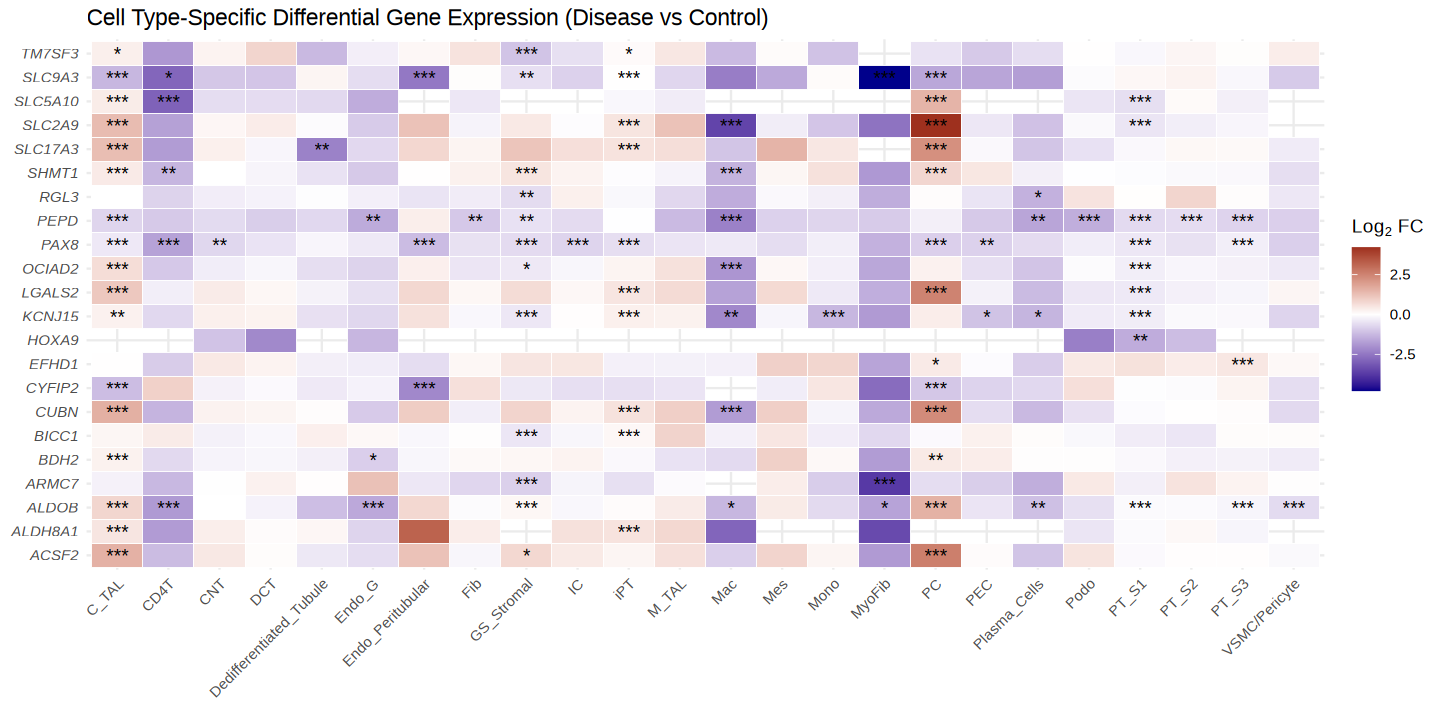

In [ ]:
# --- 0. Define Genes of Interest ---

# Define the list of genes of interest
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# --- 1. Filter Missing Genes (Handles 'subscript out of bounds' Error) ---

# Get the list of all genes present in the RNA assay
present_genes <- rownames(seurat_combined[["RNA"]])

# Identify which of your genes are NOT in the object
missing_genes <- setdiff(genes_of_interest, present_genes)

if (length(missing_genes) > 0) {
    cat("🛑 WARNING: The following genes are missing and will be skipped:\n")
    print(missing_genes)
}

# Create the clean list for analysis
genes_of_interest_clean <- setdiff(genes_of_interest, missing_genes)

if (length(genes_of_interest_clean) == 0) {
    stop("ERROR: No genes of interest remain after filtering. Cannot run DGE.")
}

# --- 2. Data Preparation & Grouping ---

# Create the essential combined grouping column (e.g., 'iPT_Disease', 'iPT_Control')
seurat_combined$celltype.status <- paste(
    seurat_combined$celltype, 
    seurat_combined$Status, 
    sep = "_"
)

# Set the new combined column as the active identity
Idents(seurat_combined) <- "celltype.status"

# Get the list of ALL possible identity levels
valid_idents <- levels(Idents(seurat_combined))

# Define the minimum cell requirement for the statistical test
MIN_CELLS_REQUIRED <- 3


# --- 3. Differential Gene Expression Testing Loop (Includes Safety Checks) ---

# Get a list of all unique cell types
cell_types <- unique(seurat_combined$celltype)

# Initialize an empty list to store results
deg_results <- list()

# Loop through each cell type
for (cell in cell_types) {
    ident_1 <- paste0(cell, "_Disease")
    ident_2 <- paste0(cell, "_Control") # Using confirmed '_Control' label

    # --- SAFETY CHECK 1: Do the identities exist? (Handles MyoFib_Healthy error) ---
    if (!(ident_1 %in% valid_idents && ident_2 %in% valid_idents)) {
        cat(paste0("\n--- Skipping ", cell, ": Required identity labels (", ident_1, " or ", ident_2, ") are missing. ---\n"))
        next
    }
    
    # --- SAFETY CHECK 2: Do both groups have enough cells? (Handles 'fewer than 3 cells' error) ---
    n_cells_disease <- length(Seurat::WhichCells(seurat_combined, idents = ident_1))
    n_cells_control <- length(Seurat::WhichCells(seurat_combined, idents = ident_2))
    
    if (n_cells_disease < MIN_CELLS_REQUIRED || n_cells_control < MIN_CELLS_REQUIRED) {
        cat(paste0("\n--- Skipping ", cell, ": Insufficient cells. Disease=", n_cells_disease, ", Control=", n_cells_control, ". Min required is ", MIN_CELLS_REQUIRED, ". ---\n"))
        next
    }
    
    # --- Execute FindMarkers if all checks pass ---
    
    cat(paste0("\n--- Running DGE for: ", cell, " (", ident_1, " vs ", ident_2, ") ---\n"))

    cell_deg <- FindMarkers(
        object = seurat_combined,
        ident.1 = ident_1,
        ident.2 = ident_2,
        features = genes_of_interest_clean,
        min.pct = 0.1,             
        logfc.threshold = 0        
    )
    
    deg_results[[cell]] <- cell_deg
}


# --- 4. Function to Add Significance Stars & Regulation Direction ---

add_significance_stars <- function(df) {
    df$Significance <- ""
    
    # Apply stars based on adjusted p-value (p_val_adj)
    df$Significance[df$p_val_adj <= 0.001] <- "***"
    df$Significance[df$p_val_adj > 0.001 & df$p_val_adj <= 0.01] <- "**"
    df$Significance[df$p_val_adj > 0.01 & df$p_val_adj <= 0.05] <- "*"
    
    # Identify regulation direction
    df$Regulation <- ifelse(df$avg_log2FC > 0, "Upregulated", "Downregulated")
    df$Regulation[df$Significance == ""] <- "No significant change"
    
    return(df)
}

# --- 5. Apply Function and Display Results ---

# Apply the function to all results in the list
deg_results_annotated <- lapply(deg_results, add_significance_stars)

cat("\n\n#####################################################\n")
cat("--- Final Annotated Results Summary ---\n")
cat("#####################################################\n")

# Print the annotated results for the 'iPT' cell type as a key example
if (!is.null(deg_results_annotated$iPT)) {
    cat("\nResults for iPT Cell Type (Disease vs Control):\n")
    print(deg_results_annotated$iPT[c("p_val_adj", "avg_log2FC", "Regulation", "Significance")])
} else {
    cat("\niPT cell type DGE was skipped due to missing groups or insufficient cells.\n")
}

cat("\n\nAll results are stored in the 'deg_results_annotated' list.\n")
# To see results for ALL cell types, uncomment and run:
# print(deg_results_annotated)




# Load necessary libraries (assuming they are available in your environment)
library(dplyr)
library(tidyr)
library(ggplot2)
library(tibble)

# --- 1. Process and Combine DGE Results ---

# Convert the list of data frames into a single data frame for plotting
plot_data_list <- list()

for (cell_type in names(deg_results_annotated)) {
    df <- deg_results_annotated[[cell_type]] %>% 
        # Convert gene names (rownames) into a column
        tibble::rownames_to_column(var = "Gene") %>%
        # Select key columns
        select(Gene, avg_log2FC, Significance) %>%
        # Add the cell type column
        mutate(CellType = cell_type)
    
    plot_data_list[[cell_type]] <- df
}

# Combine all data frames into one
dge_plot_data <- bind_rows(plot_data_list)

# Remove results where significance was "No significant change" for cleaner visualization
# (Optional: you can comment this line out if you want to see all genes)
dge_plot_data <- dge_plot_data %>% 
    filter(Significance != "No significant change")


# --- 2. Plotting the Heatmap of log2FC and Significance ---

# Factor the CellType for desired order (optional, adjust levels as needed)
# dge_plot_data$CellType <- factor(dge_plot_data$CellType, levels = rev(unique(dge_plot_data$CellType)))

DGE_Heatmap <- ggplot(dge_plot_data, aes(x = CellType, y = Gene, fill = avg_log2FC)) +
    
    # 1. Create the base heatmap tiles
    geom_tile(color = "white") +
    
    # 2. Add significance stars as text labels
    geom_text(aes(label = Significance), color = "black", size = 4) +
    
    # 3. Define the color gradient (Blue=Downregulated in Disease, Red=Upregulated in Disease)
    scale_fill_gradient2(
        low = "darkblue", 
        mid = "white", 
        high = "darkred", 
        midpoint = 0, 
        name = expression(Log[2]~FC) # Label the legend
    ) +
    
    # 4. Improve aesthetics and readability
    labs(
        title = "Cell Type-Specific Differential Gene Expression (Disease vs Control)",
        x = NULL,
        y = NULL
    ) +
    theme_minimal() +
    theme(
        # Rotate X-axis labels for readability
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), 
        # Make Y-axis labels clear
        axis.text.y = element_text(face = "italic"),
        # Adjust legend position
        legend.position = "right" 
    )

# Print or save the plot
print(DGE_Heatmap)


In [ ]:

# To save the plot:
# ggsave("DGE_Results_Heatmap.png", DGE_Heatmap, width = 10, height = 8)


# 1. Set Plot Size Options (Optional, but good practice for readability)
options(
    repr.plot.width = 12,
    repr.plot.height = 6
)

# 2. Define the list of genes of interest (from your previous prompt)
genes_of_interest <- c(
    "ALDOB", "ALDH8A1", "NAT8B", "SLC5A10", "PAX8", "CUBN", "SLC17A3", "ACSF2", "ARMC7",
    "BDH2", "BICC1", "CRB2", "CYFIP2", "EFHD1", "HOXA9", "KCNJ15", "LGALS2", "OCIAD2",
    "PEPD", "RGL3", "SHMT1", "SLC2A9", "SLC9A3", "TM7SF3"
)

# 3. Generate the DotPlot with explicit scale titles

DotPlot(
    object = seurat_combined, 
    features = genes_of_interest, 
    group.by = "celltype", 
    split.by = "Status",
    cols = c("blue", "red") # Colors for the 'Status' split
) + 
RotatedAxis() + 
# Define the Expression Level (Color) Scale (from previous request)
ggplot2::scale_colour_gradient2(
    low = "lightgrey",
    mid = "yellow",
    high = "darkred",
    midpoint = 0.5,
    name = "Avg. Expression"
) +
# Define the Dot Size Scale to explicitly label it as percentage
ggplot2::scale_size(
    range = c(0, 10), # Adjust the dot size range if needed
    name = "Percent of Cells Expressing (%)"
)